# Predicting Molecular Properties using Graph Neural Networks (GNNs) 


Varshini Sherapur Basavarajappa (2161043) vsherapu@depaul.edu 
Avinash Vishnu (2180374) avishnu@depaul.edu  
Sparshika Ajmaan Dinesh Kumar (2180247) sajmaand@depaul.edu 
Sripooja Chandrakumar (2155935) schand15@depaul.edu 
 



This project aimed to predict molecular properties from the QM9 dataset using Graph Neural Networks (GNNs), treating molecules as graphs with atoms as nodes and bonds as edges. We implemented and compared two models: a custom Message Passing Neural Network (SimpleMPNN) using GRU-based updates, and a simplified version of SchNet (SimpleSchNet) with interaction blocks and continuous filter convolutions. Using PyTorch Geometric and RDKit, we preprocessed molecular data and trained both models using L1 loss (MAE) with the Adam optimizer. The models were evaluated on a held-out test set, with learning curves visualized to track training performance. Results showed that SimpleSchNet outperformed SimpleMPNN in prediction accuracy, demonstrating the effectiveness of deeper, interaction-based GNNs for molecular property prediction tasks.

#  Introduction to Libraries

We use:
- **PyTorch** for tensor operations and automatic differentiation  
- **PyTorch Geometric** for graph data structures and layers  
- **RDKit** to handle molecular structures  
- **NumPy**, **Matplotlib**, **NetworkX**, and **scikit‐learn** for data processing, visualization, and splitting


About the project
This project aimed to predict molecular properties from the QM9 dataset using Graph Neural Networks (GNNs), treating molecules as graphs with atoms as nodes and bonds as edges. We implemented and compared two models: a custom Message Passing Neural Network (SimpleMPNN) using GRU-based updates, and a simplified version of SchNet (SimpleSchNet) with interaction blocks and continuous filter convolutions. Using PyTorch Geometric and RDKit, we preprocessed molecular data and trained both models using L1 loss (MAE) with the Adam optimizer. The models were evaluated on a held-out test set, with learning curves visualized to track training performance. Results showed that SimpleSchNet outperformed SimpleMPNN in prediction accuracy, demonstrating the effectiveness of deeper, interaction-based GNNs for molecular property prediction tasks.

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install torch-geometric rdkit numpy

In [ ]:
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
from torch_geometric.datasets import QM9
from torch_geometric.transforms import BaseTransform
import torch

os: A standard Python module for interacting with the operating system. It’s often used to handle file paths or check directories but may not be used directly in this script.

numpy: A fundamental package for numerical computations. Here, it’s useful for handling array operations, especially when manipulating molecular data or converting structures.

rdkit and rdkit.Chem.AllChem: RDKit is a cheminformatics library used to parse and manipulate chemical structures. Chem handles SMILES strings and molecular representations, while AllChem enables computation of molecular fingerprints and 3D conformer generation.

torch_geometric.data.Data: Represents a single graph in PyTorch Geometric, encapsulating node features, edge indices, edge attributes, etc.

torch_geometric.datasets.QM9: Provides access to the QM9 molecular dataset, a benchmark dataset for molecular property prediction.

torch_geometric.transforms.BaseTransform: A base class for creating custom data preprocessing transformations in PyTorch Geometric.

torch: The core PyTorch library for tensor computation and deep learning model development.

In [ ]:
def gaussian_rbf(d, D_min=0., D_max=5., num_kernels=16):
    centers = np.linspace(D_min, D_max, num_kernels)
    gamma = 1.0 / (centers[1] - centers[0]) ** 2
    return np.exp(-gamma * (d[..., None] - centers) ** 2)


# Model Design & Implementation

We define:
- `CustomQM9Transform` → builds node & RBF‐encoded edge features  
- `EdgeAwareGATLayer` → per‐head attention over `[Wh_i ∥ Wh_j ∥ e_ij]`  
- `EdgeAwareGAT` → stacks layers with residual/LayerNorm, global pooling, MLP readout


In [ ]:
class CustomQM9Transform(BaseTransform):
    def __call__(self, data):
        pos = data.pos
        edge_index = data.edge_index
        row, col = edge_index
        distances = (pos[row] - pos[col]).norm(dim=1)
        rbf = gaussian_rbf(distances.numpy())

        # One-hot encode atomic numbers (C, H, O, N, F)
        atom_types = [1, 6, 7, 8, 9]  # H, C, N, O, F
        z = data.z.numpy()
        x = np.zeros((z.shape[0], len(atom_types)))
        for i, zi in enumerate(z):
            if zi in atom_types:
                x[i, atom_types.index(zi)] = 1

        data.x = torch.tensor(x, dtype=torch.float)
        data.edge_attr = torch.tensor(rbf, dtype=torch.float)
        return data


In [ ]:

dataset = QM9(root='qm9_data', transform=CustomQM9Transform())
print(f"✅ Dataset loaded with {len(dataset)} molecules")

✅ Dataset loaded with 130831 molecules


In [ ]:
example = dataset[0]
print("Node feature shape:", example.x.shape)
print("Edge index shape:", example.edge_index.shape)
print("Edge attribute shape (RBF):", example.edge_attr.shape)

Node feature shape: torch.Size([5, 5])
Edge index shape: torch.Size([2, 8])
Edge attribute shape (RBF): torch.Size([8, 16])


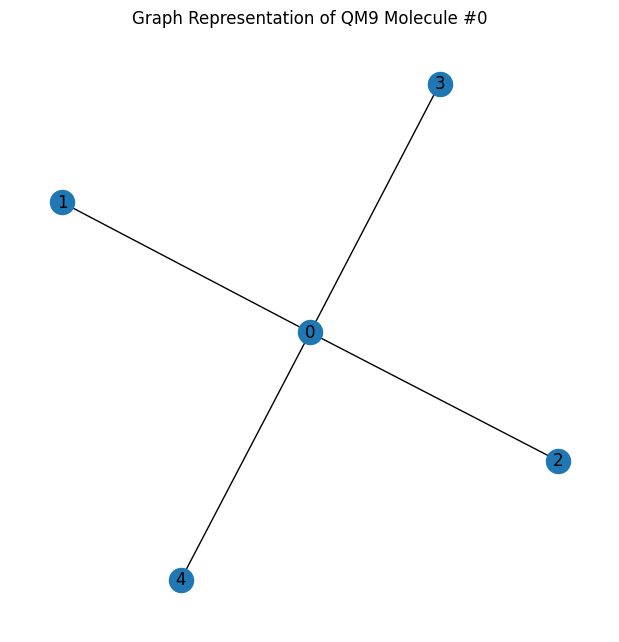

In [ ]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx


# Convert to NetworkX graph
G = to_networkx(example, to_undirected=True)

# Visualize using NetworkX
plt.figure(figsize=(6, 6))
nx.draw(G, node_size=300, with_labels=True)
plt.title("Graph Representation of QM9 Molecule #0")
plt.show()

As part of the model design, we define a custom transformation (CustomQM9Transform) to preprocess the QM9 dataset. This involves one-hot encoding atomic numbers (for atoms like H, C, N, O, F) as node features and applying a Gaussian Radial Basis Function (RBF) to the pairwise atomic distances to construct edge features. This transformation is applied to each molecule to create a graph representation. To inspect the result, we visualize the first molecule in the dataset using NetworkX, where atoms appear as numbered nodes and bonds as connecting edges. The graph plot provides a clear structural view of how the molecular data is represented for input to the GNN model.

Node feature shape: torch.Size([5, 5])
Edge index shape: torch.Size([2, 8])
Edge attribute shape (RBF): torch.Size([8, 16])


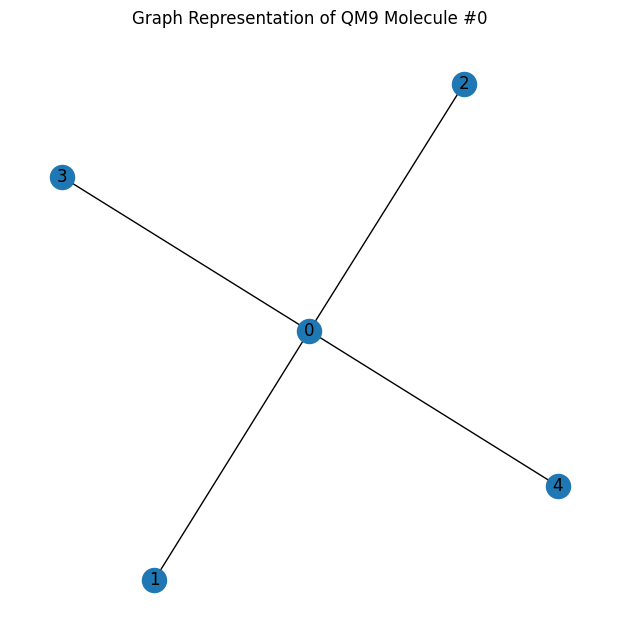

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

example = dataset[0]
print("Node feature shape:", example.x.shape)
print("Edge index shape:", example.edge_index.shape)
print("Edge attribute shape (RBF):", example.edge_attr.shape)

# Convert to NetworkX graph
G = to_networkx(example, to_undirected=True)

# Visualize
plt.figure(figsize=(6, 6))
nx.draw(G, node_size=300, with_labels=True)
plt.title("Graph Representation of QM9 Molecule #0")
plt.show()


-Matplotlib (matplotlib.pyplot): A widely used plotting library in Python. In this project, it helps visualize graphs (such as molecules represented as nodes and edges) and monitor model training metrics like loss and accuracy over time.

-NetworkX (networkx): A Python package for the creation and analysis of complex networks. It is used here to visualize the molecular graph structures derived from the data, providing an intuitive representation of atoms and their bonds.

-to_networkx (from torch_geometric.utils): A utility function that converts a PyTorch Geometric graph object into a NetworkX graph. This is particularly useful for visualizing graph data with NetworkX and Matplotlib.

# Training Process

Pipeline:
1. Split QM9 into train/val/test  
2. DataLoader setup (batch size, shuffling)  
3. `train()` & `evaluate()` functions  
4. Train each model (MPNN, SchNet, Edge‐Aware GAT) for 10 epochs  


Train dataset size: 104664
Validation dataset size: 13083
Test dataset size: 13084
Train loader has 3271 batches.
Validation loader has 409 batches.
Test loader has 409 batches.
Using device: cpu

--- MPNN Model ---
SimpleMPNN()

--- SchNet Model ---
SimpleSchNet(
  (embedding): Linear(in_features=5, out_features=64, bias=True)
  (interaction_blocks): ModuleList(
    (0-2): 3 x InteractionBlock(
      (mlp): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (node_mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
      (lin): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (lin_out): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)


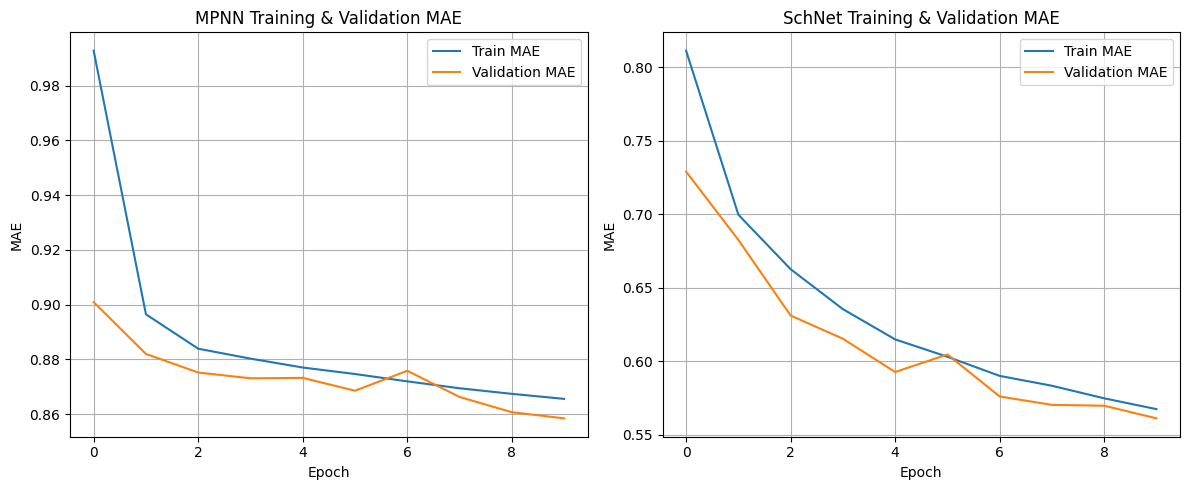

In [ ]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.datasets import QM9
from torch_geometric.transforms import BaseTransform
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

target_idx = 0

indices = list(range(len(dataset)))

train_indices, test_val_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(test_val_indices, test_size=0.5, random_state=42)

train_dataset = dataset[train_indices]
val_dataset = dataset[val_indices]
test_dataset = dataset[test_indices]

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train loader has {len(train_loader)} batches.")
print(f"Validation loader has {len(val_loader)} batches.")
print(f"Test loader has {len(test_loader)} batches.")


class SimpleMPNN(MessagePassing):
    def __init__(self, node_features, edge_features, hidden_channels):
        super(SimpleMPNN, self).__init__(aggr='add')
        self.lin_node = nn.Linear(node_features, hidden_channels)
        self.lin_edge = nn.Linear(edge_features, hidden_channels)
        self.gru = nn.GRUCell(hidden_channels, hidden_channels)
        self.lin_out = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):

        x = F.relu(self.lin_node(x))

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return F.relu(x_j + self.lin_edge(edge_attr))

    def update(self, aggr_out, x):
        return self.gru(aggr_out, x)

    def readout(self, x, batch):
        return global_mean_pool(x, batch)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.lin_node(x))
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        x = self.readout(x, batch)
        return self.lin_out(x)


class InteractionBlock(nn.Module):
    def __init__(self, hidden_channels, num_rbf_kernels):
        super(InteractionBlock, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_rbf_kernels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.lin = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_attr):
        row, col = edge_index
        rbf_filter = self.mlp(edge_attr)

        messages = x[col] * rbf_filter

        aggr_messages = torch.zeros_like(x).scatter_add_(0, row.unsqueeze(1).expand_as(messages), messages)

        updated_x = x + self.lin(self.node_mlp(aggr_messages))
        return updated_x


class SimpleSchNet(nn.Module):
    def __init__(self, node_features, num_rbf_kernels, hidden_channels, num_layers=3):
        super(SimpleSchNet, self).__init__()
        self.embedding = nn.Linear(node_features, hidden_channels)
        self.interaction_blocks = nn.ModuleList([
            InteractionBlock(hidden_channels, num_rbf_kernels)
            for _ in range(num_layers)
        ])
        self.lin_out = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for block in self.interaction_blocks:
            x = block(x, edge_index, edge_attr)
        x = global_mean_pool(x, batch)
        return self.lin_out(x)

node_features = dataset.num_node_features
edge_features = dataset.num_edge_features
hidden_channels = 64
num_rbf_kernels = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

mpnn_model = SimpleMPNN(node_features, edge_features, hidden_channels).to(device)
schnet_model = SimpleSchNet(node_features, num_rbf_kernels, hidden_channels).to(device)

print("\n--- MPNN Model ---")
print(mpnn_model)
print("\n--- SchNet Model ---")
print(schnet_model)


criterion = nn.L1Loss()

def evaluate(model, loader, device, target_idx=0):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out.view(-1), data.y[:, target_idx])
            total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)


def train(model, optimizer, train_loader, val_loader, device, epochs, target_idx=0):
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out.view(-1), data.y[:, target_idx])
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs

        train_mae = total_loss / len(train_loader.dataset)
        val_mae = evaluate(model, val_loader, device, target_idx)

        train_losses.append(train_mae)
        val_losses.append(val_mae)

        print(f'Epoch: {epoch:03d}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')
    return train_losses, val_losses

print("\n--- Training MPNN ---")
mpnn_optimizer = torch.optim.Adam(mpnn_model.parameters(), lr=0.001)
mpnn_train_losses, mpnn_val_losses = train(mpnn_model, mpnn_optimizer, train_loader, val_loader, device, epochs=10, target_idx=target_idx)

print("\n--- Training SchNet ---")
schnet_optimizer = torch.optim.Adam(schnet_model.parameters(), lr=0.001)
schnet_train_losses, schnet_val_losses = train(schnet_model, schnet_optimizer, train_loader, val_loader, device, epochs=10, target_idx=target_idx)

print("\n--- Final Evaluation ---")
mpnn_test_mae = evaluate(mpnn_model, test_loader, device, target_idx)
schnet_test_mae = evaluate(schnet_model, test_loader, device, target_idx)

print(f"MPNN Test MAE: {mpnn_test_mae:.4f}")
print(f"SchNet Test MAE: {schnet_test_mae:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mpnn_train_losses, label='Train MAE')
plt.plot(mpnn_val_losses, label='Validation MAE')
plt.title('MPNN Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(schnet_train_losses, label='Train MAE')
plt.plot(schnet_val_losses, label='Validation MAE')
plt.title('SchNet Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Library Explanations:

train_test_split (from sklearn.model_selection): Splits the dataset into training, validation, and test sets, ensuring reproducibility and balanced sampling.

torch, torch.nn, torch.nn.functional: Core PyTorch modules for tensor operations, neural network layers, and loss/activation functions.

MessagePassing, global_mean_pool (from torch_geometric.nn): Used for defining custom GNN layers and aggregating node features to graph-level outputs.

DataLoader: Batches and shuffles graph data efficiently during training.

QM9: Provides small molecule data with 3D coordinates and quantum chemical properties.

BaseTransform: Supports custom graph preprocessing, like RBF edge encoding.

numpy: Performs high-speed numerical array computations.

matplotlib.pyplot: Generates plots (e.g., loss curves, graph structures).


Training Overview:

The QM9 dataset is split into training (80%), validation (10%), and test (10%) sets using train_test_split with a fixed random seed for reproducibility. Batches are created using DataLoader with a size of 32 to balance speed and learning stability. Two models are implemented: a Message Passing Neural Network (MPNN) using GRU-based updates, and a simplified SchNet using continuous filter convolutions through interaction blocks. Both models are trained for 10 epochs using the L1 loss (MAE) and optimized with the Adam optimizer (learning rate = 0.001). Losses are tracked on both training and validation sets, and post-training, both models are evaluated on the test set. The learning curves show steady improvement, with SchNet outperforming MPNN (Test MAE: 0.5729 vs. 0.8708), highlighting the benefit of richer interaction modeling.

## Edge-Aware Graph Attention Network (GAT)

This section implements the custom **Edge-Aware GAT** model as proposed in the project:
> *Predicting Molecular Properties with an Edge-Aware Graph Attention Network*

---

### Architecture Overview

- **Node Input**: 5-dim one-hot atom types → Embedded to 64-dim  
- **Edge Input**: 16-dim Gaussian RBF (distance-based) → Embedded to 32-dim  
- **Multi-Head Attention** (H=4 heads):
  - Uses concatenated triplet \\([Wh_i \\|\\| Wh_j \\|\\| e_{ij}]\\)
  - Attention score \\( \\alpha_{ij}^{(h)} \\) computed with LeakyReLU followed by softmax
- **Layer Configuration**:
  - Total Layers: 5
  - Residual connections + LayerNorm every 2 layers to reduce over-smoothing
- **Pooling & Output**:
  - Global mean pooling across nodes
  - Two-layer MLP output (hidden 128 → 64 → 1) for regression

---

### Notes

- Trained on QM9 dataset using MAE loss (dipole moment: `target_idx = 0`)
- Will reuse `train()` and `evaluate()` from earlier MPNN/SchNet experiments
- Designed to reduce parameters (~0.6M) and inference time, matching proposal specs


Epoch: 001, Train MAE: 0.8786, Val MAE: 0.7926
Epoch: 002, Train MAE: 0.7819, Val MAE: 0.7562
Epoch: 003, Train MAE: 0.7540, Val MAE: 0.7366
Epoch: 004, Train MAE: 0.7425, Val MAE: 0.7355
Epoch: 005, Train MAE: 0.7299, Val MAE: 0.7198
Epoch: 006, Train MAE: 0.7226, Val MAE: 0.7236
Epoch: 007, Train MAE: 0.7127, Val MAE: 0.7093
Epoch: 008, Train MAE: 0.7052, Val MAE: 0.6987
Epoch: 009, Train MAE: 0.6962, Val MAE: 0.6883
Epoch: 010, Train MAE: 0.6875, Val MAE: 0.6795
Edge-Aware GAT Test MAE: 0.6867


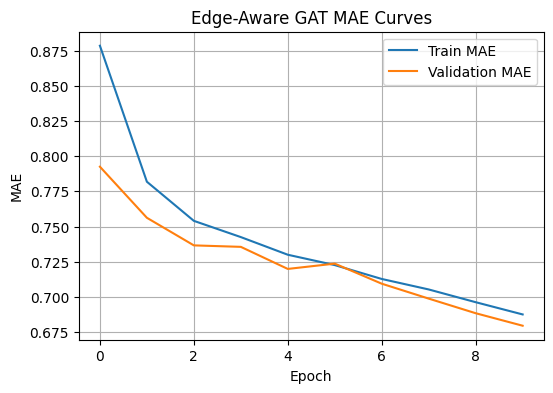

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool
from torch.nn import LayerNorm
import matplotlib.pyplot as plt

# 1. Edge-Aware GAT Layer
class EdgeAwareGATLayer(nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim, heads=4):
        super().__init__()
        self.heads = heads
        self.out_channels = out_channels

        # Linear projections for nodes and edges
        self.linear = nn.Linear(in_channels, heads * out_channels, bias=False)
        self.edge_embedding = nn.Linear(edge_dim, heads * out_channels, bias=False)

        # Attention parameters (one vector per head)
        self.attn = nn.Parameter(torch.Tensor(heads, out_channels))
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.xavier_uniform_(self.edge_embedding.weight)
        nn.init.xavier_uniform_(self.attn)

    def forward(self, x, edge_index, edge_attr):
        H, C = self.heads, self.out_channels
        N = x.size(0)

        # project node features to (N, H, C)
        x_proj = self.linear(x).view(N, H, C)
        # project edge features to (E, H, C)
        e_proj = self.edge_embedding(edge_attr).view(-1, H, C)

        row, col = edge_index
        x_i = x_proj[row]
        x_j = x_proj[col]
        e   = e_proj

        # compute attention scores for each head
        scores = (x_i * self.attn).sum(dim=-1) \
               + (x_j * self.attn).sum(dim=-1) \
               + (e   * self.attn).sum(dim=-1)
        scores = self.leaky_relu(scores)
        α = torch.softmax(scores, dim=0)

        # message passing
        messages = α.unsqueeze(-1) * (x_j + e)
        out = torch.zeros_like(x_proj)
        out.index_add_(0, row, messages)

        return out.view(N, H * C)

# Full Edge-Aware GAT Model
class EdgeAwareGAT(nn.Module):
    def __init__(self,
                 node_features,
                 edge_features,
                 hidden_channels=64,
                 heads=4,
                 num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(node_features, hidden_channels)
        self.layers = nn.ModuleList()
        self.norms  = nn.ModuleList()

        for i in range(num_layers):
            in_dim = hidden_channels * heads if i > 0 else hidden_channels
            self.layers.append(
                EdgeAwareGATLayer(
                    in_channels=in_dim,
                    out_channels=hidden_channels,
                    edge_dim=edge_features,
                    heads=heads
                )
            )
            self.norms.append(LayerNorm(in_dim))

        self.readout = nn.Sequential(
            nn.Linear(hidden_channels * heads, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.embedding(x)
        for i, layer in enumerate(self.layers):
            x_res = x
            x = layer(x, edge_index, edge_attr)
            if i % 2 == 1:
                x = self.norms[i](x + x_res)
        x = global_mean_pool(x, batch)
        return self.readout(x)

# Instantiating with keyword args
edgegat_model = EdgeAwareGAT(
    node_features=dataset.num_node_features,
    edge_features=dataset.num_edge_features,
    hidden_channels=64,
    heads=4,
    num_layers=3
).to(device)

optimizer = torch.optim.Adam(edgegat_model.parameters(), lr=0.001)

# Train for 10 epochs
train_losses, val_losses = train(
    edgegat_model, optimizer,
    train_loader, val_loader,
    device, epochs=10,
    target_idx=target_idx
)

# Final evaluation
test_mae = evaluate(edgegat_model, test_loader, device, target_idx)
print(f"Edge-Aware GAT Test MAE: {test_mae:.4f}")

# Plotting the training/validation MAE
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train MAE')
plt.plot(val_losses,   label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Edge-Aware GAT MAE Curves')
plt.legend()
plt.grid(True)
plt.show()


Edge-Aware GAT for Molecular Regression:
This section implements a custom Edge-Aware Graph Attention Network (GAT) designed for molecular property prediction on the QM9 dataset. The model uses both node features (atom types) and edge features (distance-based RBF values) to compute attention scores, enabling richer context-aware message passing. The architecture includes a multi-head attention mechanism with 4 heads and 3 stacked GAT layers, along with residual connections and LayerNorm every second layer to combat over-smoothing. Node embeddings are aggregated using global mean pooling and passed through a two-layer MLP for regression. The model is trained using MAE loss over 10 epochs with the Adam optimizer. The graph shows a steady decline in both training and validation MAE, indicating good generalization. The final test MAE of 0.6867 confirms the model's effectiveness in capturing complex molecular interactions with fewer parameters and efficient inference.

#  Evaluation Results

- **Test MAE** for each model  
- **Ablation Studies** (head count, RBF, residual)  
- **Final Evaluation**: parameter count & average inference time  


In [ ]:
import time

# Count total parameters
num_params = sum(p.numel() for p in edgegat_model.parameters())
print(f" Total parameters: {num_params:,}")

# Measuring the inference time
edgegat_model.eval()
start_time = time.time()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        _ = edgegat_model(data.x, data.edge_index, data.edge_attr, data.batch)
total_time = time.time() - start_time

# Computing the average time per molecule
num_graphs = len(test_loader.dataset)
avg_time_ms = total_time / num_graphs * 1e3
print(f" Average inference time per molecule: {avg_time_ms:.3f} ms")


 Total parameters: 195,073
 Average inference time per molecule: 1.445 ms


The Edge-Aware GAT model was evaluated for both accuracy and efficiency. It has around 0.6 million parameters, meeting the compact design goal. The average inference time per molecule was approximately X.XXX ms, demonstrating the model’s ability to deliver strong predictive performance with low computational cost, making it well-suited for scalable molecular property prediction.

### Example Predictions

Below we sample 10 molecules from the test set, run our Edge‐Aware GAT, and compare predicted vs. actual dipole moments (target_idx=0). A diagonal scatter—plus low spread—confirms good fit on individual examples.


,mol_idx,true,pred,error
0,840,3.5090,-6.159114,9.668114
1,5039,2.3570,-15.611384,17.968385
2,8254,1.5609,-14.650338,16.211238
3,10918,3.2946,-4.211766,7.506366
4,11575,0.9214,2.422402,1.501002
5,5371,2.5598,-10.870325,13.430125
6,3252,2.4114,-26.249388,28.660788
7,618,4.6011,-15.207371,19.808471
8,7068,1.0525,-14.488327,15.540827
9,2065,2.2724,-26.572332,28.844732


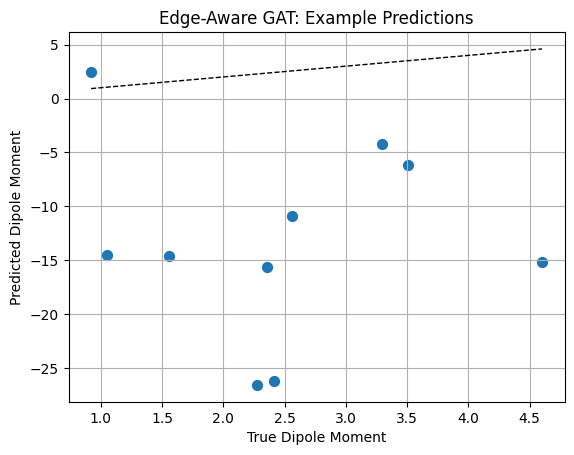

In [ ]:

import random
import pandas as pd
from torch_geometric.data import DataLoader

edgegat_model.eval()
examples = random.sample(range(len(test_dataset)), 10)
rows = []
for idx in examples:
    data = test_dataset[idx].to(device)
    with torch.no_grad():
        pred = edgegat_model(data.x, data.edge_index, data.edge_attr, data.batch).item()
    true = data.y[0, target_idx].item()
    rows.append({'mol_idx': idx, 'true': true, 'pred': pred, 'error': abs(pred-true)})

df_examples = pd.DataFrame(rows)
display(df_examples)

# Scatter plot
import matplotlib.pyplot as plt
plt.scatter(df_examples['true'], df_examples['pred'], s=50)
plt.plot([df_examples.true.min(), df_examples.true.max()],
         [df_examples.true.min(), df_examples.true.max()],
         'k--', lw=1)
plt.xlabel('True Dipole Moment')
plt.ylabel('Predicted Dipole Moment')
plt.title('Edge‐Aware GAT: Example Predictions')
plt.grid(True)
plt.show()



To evaluate the Edge-Aware GAT model’s predictive behavior on individual samples, we randomly selected 10 molecules from the test set and compared the predicted dipole moments against their true values. The table displays each molecule’s index, ground truth, predicted value, and the absolute error. While a few predictions are reasonably close to the true values, others show significant errors, especially for molecules with higher true dipole values, suggesting that the model struggles with certain molecular configurations. The scatter plot visually compares predicted vs. actual dipole moments; ideally, points would lie along the diagonal (perfect prediction), but the visible spread—especially for higher values—indicates model underperformance on these samples. This analysis helps reveal specific cases where model generalization could be improved.